<a href="https://colab.research.google.com/github/chemoinformatics-lecture/lecture-beginner/blob/main/lesson07_automl/lecture_note_regression_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 行うこと

これまでの授業の復習として以下のことを行ってください。
1. データをダウンロードする
2. Pubchem,RDKit,MOPACなどを用いて説明変数を作成する。
3. 機械学習を用いて、テストデータの予測を行う。
4. テストデータの予測値を課題提出場所に提出してください｡

# pycaretの関数

1. データの前処理：　setup()
2. モデルの比較： compare_models()
3. 分析モデルの生成： create_model()
4. チューニング： tune_model()
5. 可視化： plot_model()
6. 評価： evaluate_model()
7. 予測： finalize_model(), predict_model()

# pycaretのインストール

In [1]:
!pip install pycaret==2.2.0
!pip install pandas-profiling==3.1.0
!pip install scikit-learn==0.23.2 --force-reinstall
# pandas-profilingのversionを落とさないと次のエラーが出る。
# PyCaret ImportError: Missing optional dependency 'Jinja2'
# https://qiita.com/hasegatk/items/c835ba6243efbb4e53d2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.8 MB 3.9 MB/s 
     |████████████████████████████████| 15.7 MB 39.7 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 297 kB 45.8 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.1.0
    Uninstalling threadpoolctl-3.1.0:
      Successfully uninstalled threadpoolctl-3.1.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
  Attempting uninstall: joblib
    Found existing installation: joblib 1.2.0
    Uninstalling joblib-1.2.0:
      Successfully uninstalled joblib-1.2.0
  Attempting uninstall: scikit-learn
 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 248 kB 4.2 MB/s 
     |████████████████████████████████| 137 kB 56.0 MB/s 
     |████████████████████████████████| 1.7 MB 50.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 315 kB 62.5 MB/s 
     |████████████████████████████████| 88 kB 7.3 MB/s 
     |████████████████████████████████| 255.9 MB 44 kB/s 
     |████████████████████████████████| 17.0 MB 225 kB/s 
     |████████████████████████████████| 76.8 MB 7.6 MB/s 
     |████████████████████████████████| 2.0 MB 49.5 MB/s 
     |████████████████████████████████| 24.8 MB 1.4 MB/s 
     |████████████████████████████████| 1.6 MB 48.5 MB/s 
     |████████████████████████████████| 9.8 MB 37.2 MB/s 
     |████████████████████████████████|

In [22]:
!pip install scikit-learn==0.23.2 --force-reinstall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_learn-0.23.2-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
  Using cached numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached scipy-1.7.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (38.1 MB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.1.0
    Uninstalling threadpoolctl-3.1.0:
      Successfully uninstalled threadpoolctl-3.1.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
  Attempting uninstall: joblib
    Found

In [8]:
#rdkitのインストール
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 36.8 MB 509 kB/s 


# 0. ライブラリーのインポート

In [2]:
import warnings
# 不要な警告文非表示
warnings.filterwarnings("ignore")


In [3]:
import pandas as pd
pd.__version__ # 1.3.5が表示

'1.3.5'

In [4]:
import pycaret
print(pycaret.__version__)  # 2.2.0が表示

2.2.0


In [5]:
import sklearn
print(sklearn.__version__) # 0.23.2が表示

0.23.2


In [6]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


# 1. データのセットアップ

In [7]:
!wget 'http://modem.ucsd.edu/adme/data/databases/logS/data_set.dat'

--2022-10-21 02:34:50--  http://modem.ucsd.edu/adme/data/databases/logS/data_set.dat
Resolving modem.ucsd.edu (modem.ucsd.edu)... 132.239.68.159
Connecting to modem.ucsd.edu (modem.ucsd.edu)|132.239.68.159|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52906 (52K) [text/plain]
Saving to: ‘data_set.dat.1’

data_set.dat.1      100%[===================>]  51.67K  99.9KB/s    in 0.5s    

2022-10-21 02:34:51 (99.9 KB/s) - ‘data_set.dat.1’ saved [52906/52906]



In [7]:
from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, PandasTools
import numpy as np

# データの呼び出しなど
df = pd.read_csv('data_set.dat', sep='\t', header=None, names = ["smiles", "CAS", "logS"]) 
PandasTools.AddMoleculeColumnToFrame(df, "smiles")
df = df.dropna(subset=['ROMol'], axis=0)
df = df.reset_index()

# fingerprintの作成
fingerprints = []
safe = []
for mol_idx, mol in enumerate(df["ROMol"]):
    try:
        fingerprint = [x for x in AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048)]
        fingerprints.append(fingerprint)
        safe.append(mol_idx)
        
    except:
        print("Error", mol_idx)
        continue
fingerprints = np.array(fingerprints)
print(fingerprints.shape)
df_fp = pd.DataFrame(fingerprints)

# dfをあわせて表示
df_comb = pd.merge(df, df_fp, left_index=True, right_index=True)

(1289, 2048)


,index,smiles,CAS,logS,ROMol,0,1,2,3,4,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,O=C(C)N,60-35-5,1.58,,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0

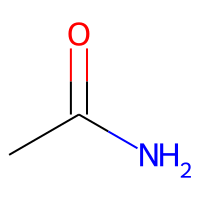

In [8]:
df_comb.head(1)

In [9]:
data = df_comb.sample(frac=0.95, random_state=786)
data_unseen = df_comb.drop(data.index).reset_index(drop=True)
data.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (1225, 2053)
Unseen Data For Predictions: (64, 2053)


In [10]:
from pycaret.regression import *
exp1 = setup(data, target = 'logS', ignore_features= ['index', 'smiles', 'CAS', 'ROMol'],silent=True, fold_shuffle=True, session_id=123)

,Description,Value
0,session_id,123
1,Target,logS
2,Original Data,"(1225, 2053)"
3,Missing Values,False
4,Numeric Features,0
5,Categorical Features,2048
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(857, 1880)"


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 0
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False,
                                      features_todrop=['index', 'smiles', 'CAS',
                                                       'ROMol'],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[], target='logS',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_num...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),

# pandas_profiling　重いです。

In [ ]:
import pandas_profiling
profile = dataset.profile_report()

In [ ]:
profile

In [ ]:
profile.to_file("myoutputfile.html")
# このファイルのままだと、一時保存場所なので、時間が経つと消えます。
# ファイルの保存場所をdriveの中にすれば、google driveに保存される。

# 2. モデルの比較： compare_models()

In [11]:
compare_models(fold=3) # デフォルトは、foldが10。時間短縮のために3にしています。

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.9210,1.483800e+00,1.216900e+00,6.394000e-01,0.3349,1.3740,52.8933
br,Bayesian Ridge,0.9189,1.493000e+00,1.219700e+00,6.377000e-01,0.3460,1.2446,2.9267
rf,Random Forest Regressor,0.9474,1.595400e+00,1.261400e+00,6.126000e-01,0.3467,1.4136,3.5767
par,Passive Aggressive Regressor,0.9690,1.619600e+00,1.270600e+00,6.066000e-01,0.3618,1.2413,0.4233
lightgbm,Light Gradient Boosting Machine,0.9858,1.649600e+00,1.284100e+00,5.982000e-01,0.3557,1.2767,0.4000
gbr,Gradient Boosting Regressor,0.9953,1.702500e+00,1.302800e+00,5.867000e-01,0.3584,1.5474,1.1700
xgboost,Extreme Gradient Boosting,0.9924,1.748500e+00,1.320500e+00,5.748000e-01,0.3612,1.3741,4.7067
ridge,Ridge Regression,1.0063,1.789000e+00,1.334700e+00,5.659000e-01,0.3768,1.2683,0.1000
knn,K Neighbors Regressor,1.1416,2.238300e+00,1.495200e+00,4.556000e-01,0.4234,1.7333,0.6333
et,Extra Trees Regressor,1.1607,2.378500e+00,1.541300e+00,4.206000e-01,0.4315,1.6255,5.0733


INFO:logs:create_model_container: 20
INFO:logs:master_model_container: 20
INFO:logs:display_container: 1
INFO:logs:<catboost.core.CatBoostRegressor object at 0x7f5bb1e68410>
INFO:logs:compare_models() succesfully completed......................................


# 3. 分析モデルの生成： create_model()

In [12]:
lr = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.9012,1.4220,1.1925,0.6336,0.3387,2.7787
1,0.8143,1.2113,1.1006,0.6788,0.3392,0.7522
2,0.9756,1.5570,1.2478,0.6849,0.3266,0.8079
3,0.8486,1.1537,1.0741,0.6233,0.3336,1.6681
4,0.8675,1.2919,1.1366,0.6553,0.3037,1.1359
5,0.9696,1.5206,1.2331,0.6745,0.3779,2.0211
6,0.9202,1.3800,1.1747,0.6217,0.3195,1.3407
7,1.0222,1.9117,1.3826,0.5340,0.3790,1.1816
8,0.7670,0.9862,0.9931,0.7383,0.2495,0.4302
9,1.0863,2.2085,1.4861,0.5791,0.3813,1.1293


INFO:logs:create_model_container: 21
INFO:logs:master_model_container: 21
INFO:logs:display_container: 2
INFO:logs:XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=123, reg_alpha=0, ...)
INFO:logs:create_model() succesfully completed......................................


# 4. チューニング： tune_model()

In [14]:
tuned_lr = tune_model(lr, optimize = "r2", fold = 3, n_iter = 5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.9638,1.5699,1.2530,0.6197,0.3627,1.4646
1,0.9182,1.3399,1.1575,0.6517,0.3378,1.2279
2,0.9128,1.7098,1.3076,0.6066,0.3441,0.8049
Mean,0.9316,1.5399,1.2394,0.6260,0.3482,1.1658
SD,0.0229,0.1525,0.0620,0.0189,0.0106,0.2729


INFO:logs:create_model_container: 22
INFO:logs:master_model_container: 22
INFO:logs:display_container: 3
INFO:logs:XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.274, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=3,
             missing=nan, monotone_constraints='()', n_estimators=200,
             n_jobs=-1, num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=123, reg_alpha=0.7, ...)
INFO:logs:tune_model() succesfully completed......................................


# 5. 可視化： plot_model()

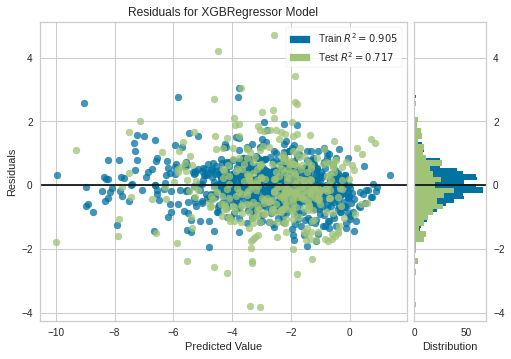

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [15]:
plot_model(tuned_lr)

# 6. 評価： evaluate_model()

In [16]:
evaluate_model(tuned_lr)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.274, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=3,
             missing=nan, monotone_constraints='()', n_estimators=200,
             n_jobs=-1, num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=123, reg_alpha=0.7, ...), fold=None, fit_kwargs=None, feature_name=None, groups=None)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

# 7. 予測： finalize_model(), predict_model()

In [17]:
final_lr = finalize_model(tuned_lr)
unseen_predictions = predict_model(final_lr)
unseen_predictions.head()

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.274, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=3,
             missing=nan, monotone_constraints='()', n_estimators=200,
             n_jobs=-1, num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=123, reg_alpha=0.7, ...), fit_kwargs=None, groups=None, model_only=True, display=None)
INFO:logs:Finalizing XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.5171,0.4586,0.6772,0.8893,0.2106,0.6297


,1_0,2_1,3_0,4_1,5_0,6_0,7_0,8_0,9_1,10_1,...,2040_0,2041_0,2042_0,2043_0,2044_1,2045_1,2046_1,2047_0,logS,Label
0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,-1.12,-1.194966
1,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,-4.88,-4.553312
2,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,-6.01,-6.023539
3,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,-6.29,-5.733081
4,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,-0.85,-0.897255


In [19]:
type(unseen_predictions)

pandas.core.frame.DataFrame

In [ ]:
unseen_predictions = predict_model(final_lr)

,logS,Label
0,-1.12,-1.194966
1,-4.88,-4.553312
2,-6.01,-6.023539
3,-6.29,-5.733081
4,-0.85,-0.897255
...,...,...
363,-4.79,-4.456745
364,-6.14,-5.824913
365,-2.23,-2.595317
366,-1.91,-1.946105


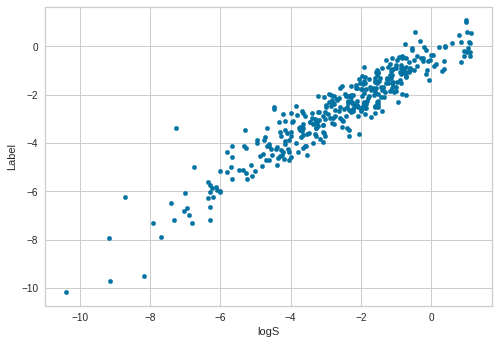

In [25]:
unseen_predictions[['logS', 'Label']].plot(kind='scatter', x='logS', y='Label')
unseen_predictions[['logS', 'Label']]

# 以上です。